In [1]:
%load_ext autoreload
%autoreload 2

# Global Greedy Activation

This notebook analyzes the results of the iterative, global greedy activation sample calculations, which are saved separately as a set of `*.csv` files. Here, we read them in and do some basic analyses in support of the assertions made in the paper.

In [2]:
import glob, os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

import numpy as np
import pandas as pd

from util import mode_colors, colortext_legend

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load in the datasets.

In [3]:
DATA_DIR = "../global_greedy_activation/arg_comp_ensemble/"
csvs = glob.glob(os.path.join(DATA_DIR, "single_timestep*.csv"))

all_dfs = []
for csv in csvs:
    print(csv)
    df = pd.read_csv(csv, index_col=0)
    all_dfs.append(df)
mode_results = pd.concat(all_dfs, ignore_index=True)
print(len(mode_results))

../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0000.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0001.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0002.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0003.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0004.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0005.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0006.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0007.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0008.csv
../global_greedy_activation/arg_comp_ensemble/single_timestep_ti_0009.csv
59560


In the original activation calculations, I didn't compute the equilibrium activation for the *entire* aerosol population - that is, applying $S_\text{max}$ to diagnose the total aerosol number activated - so I had to go back and re-calculate this. We can directly concatenate these columns onto the sample dataset.

In [4]:
nact_df = pd.read_csv(os.path.join(DATA_DIR, 'iter_nact.csv'), index_col=0)
mode_results = pd.concat([mode_results, nact_df], axis=1)

## Iteration Fractions

In these first sets of quick calculations, we assess the frequency of each mode occuring as the "dominant" one, and then extend to subsequent iterations.

### Iteration 1

In [5]:
i1_groups = mode_results.groupby('MODE_01')
i1_pct = 100.*(i1_groups.size()/len(mode_results))
print(i1_pct)

MODE_01
ACC      96.495970
DST01     0.142713
MBS       1.145064
MOS       2.216253
dtype: float64


### Iteration 2

In [6]:
i2_groups = mode_results.groupby(['MODE_01', 'MODE_02'])
i2_n = i2_groups.size()
i2_pct = i2_n.groupby(level=0).apply(lambda g: 100.*g/g.sum())
print("Pct in second iter\n", i2_pct)
print("\n\n")
print("Pct overall\n", 100.*i2_n/len(mode_results))

Pct in second iter
 MODE_01  MODE_02
ACC      DST01       0.742958
         MBS        10.321368
         MOS        36.164808
         SSLT01     52.770866
DST01    ACC        32.941176
         DST02      44.705882
         MOS        22.352941
MBS      ACC        36.070381
         DST01       0.586510
         MOS        63.343109
MOS      ACC        45.681818
         DST01       1.590909
         MBS        52.727273
dtype: float64



Pct overall
 MODE_01  MODE_02
ACC      DST01       0.716924
         MBS         9.959704
         MOS        34.897582
         SSLT01     50.921760
DST01    ACC         0.047011
         DST02       0.063801
         MOS         0.031901
MBS      ACC         0.413029
         DST01       0.006716
         MOS         0.725319
MOS      ACC         1.012424
         DST01       0.035259
         MBS         1.168570
dtype: float64


## Hierarchical (full-leaf) Dataset Construction

In [7]:
from itertools import permutations
mode_names = ['AIT', 'ACC', 'MBS', 'MOS', 'DST01', 'DST02', 'DST03', 'DST04', 
              'SSLT01', 'SSLT02', 'SSLT03', 'SSLT04']
multi_labels = list(permutations(mode_names, 3))

full_index = pd.MultiIndex.from_tuples(multi_labels, 
                                       names=['MODE_01', 'MODE_02', 'MODE_03'])
data = mode_results.groupby(['MODE_01', 'MODE_02', 'MODE_03']).size()
data_pct = 100.*data/(np.sum(data))

data = pd.DataFrame({'pct': data_pct, 'count': data})
data_full = data.reindex(full_index, fill_value=0, copy=True)
mask = data_full['pct'] > 0.

print(data_full[mask])

                         count        pct
MODE_01 MODE_02 MODE_03                  
ACC     MBS     MOS       5782   9.707858
                DST01       26   0.043653
                SSLT01     124   0.208193
        MOS     MBS      15376  25.815984
                DST01      149   0.250168
                SSLT01    5260   8.831430
        DST01   MBS         88   0.147750
                MOS        149   0.250168
                DST02      187   0.313969
                SSLT01       3   0.005037
        SSLT01  MBS        776   1.302888
                MOS      29360  49.294829
                DST01        6   0.010074
                SSLT03     187   0.313969
MBS     ACC     MOS        235   0.394560
                DST01       11   0.018469
        MOS     ACC        428   0.718603
                DST01        4   0.006716
        DST01   ACC          3   0.005037
                MOS          1   0.001679
MOS     ACC     MBS        589   0.988919
                DST01        8   0

What mode combinations add up to the most frequent dominating combinations?

In [8]:
mode3_sorted = (
    data_full[mask]
    .sort('pct', ascending=False)
    .assign(cum_pct=lambda x: x['pct'].cumsum())
)
print(mode3_sorted)

                         count        pct     cum_pct
MODE_01 MODE_02 MODE_03                              
ACC     SSLT01  MOS      29360  49.294829   49.294829
        MOS     MBS      15376  25.815984   75.110813
        MBS     MOS       5782   9.707858   84.818670
        MOS     SSLT01    5260   8.831430   93.650101
        SSLT01  MBS        776   1.302888   94.952989
MOS     MBS     ACC        690   1.158496   96.111484
        ACC     MBS        589   0.988919   97.100403
MBS     MOS     ACC        428   0.718603   97.819006
        ACC     MOS        235   0.394560   98.213566
ACC     DST01   DST02      187   0.313969   98.527535
        SSLT01  SSLT03     187   0.313969   98.841504
        MOS     DST01      149   0.250168   99.091672
        DST01   MOS        149   0.250168   99.341840
        MBS     SSLT01     124   0.208193   99.550034
        DST01   MBS         88   0.147750   99.697784
DST01   DST02   ACC         27   0.045332   99.743116
ACC     MBS     DST01       

/Users/daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


## Relative Error Plots

Using the case where "all" the modes participate in activation, we can analyze how the relative error decreases on subsequent iterations of the greedy calculations and converges to the benchmark calculation.

First, we have to calculate relative errors aggregated by each iteration. We have three diagnostics computed at each iteration:

- **SMAX** - the supersaturation maximum achieved in the parcel
- **EQ** - the number concentration activated using equilibrium-Köhler theory assumptions
- **KN** - the "true", kinetically-limited number concentration activated, accounting
  for particles which have not yet grown past their critical size

In [9]:
niters = 3
iter_range = range(1, niters+1)

df_err = mode_results.copy(deep=True)
for it in iter_range:
    smax_all, eq_all, kn_all = mode_results['SMAX_all'], mode_results['EQ_all'], \
                               mode_results['KN_all']
    # There's a naming bug in the script that computes the total activation,
    # so we correct that here. This means that we *can't* use niters=4
    n_act_all = mode_results['N_ACT_04']
    smax_iter, eq_iter, kn_iter = mode_results['SMAX_%02d' % it], \
                                  mode_results['EQ_%02d' % it], \
                                  mode_results['KN_%02d' % it]
    n_act_iter = mode_results['N_ACT_%02d' % it]
    
    df_err['smax_err_abs_%02d' % it] = smax_iter - smax_all
    df_err['smax_err_rel_%02d' % it] = 100.*(smax_iter - smax_all)/smax_all
    df_err['eq_err_abs_%02d' % it] = eq_iter - eq_all
    df_err['eq_err_rel_%02d' % it] = 100.*(eq_iter - eq_all)/eq_all
    df_err['kn_err_abs_%02d' % it] = kn_iter - kn_all
    df_err['kn_err_rel_%02d' % it] = 100.*(kn_iter - kn_all)/kn_all
    df_err['n_act_err_abs_%02d' % it] = n_act_iter - n_act_all
    df_err['n_act_err_rel_%02d' % it] = 100.*(n_act_iter - n_act_all)/n_act_all
df_err[df_err == np.inf] = np.nan
df_err.dropna(inplace=True)

In [10]:
tidy_df_err = df_err.copy()

11.2 4


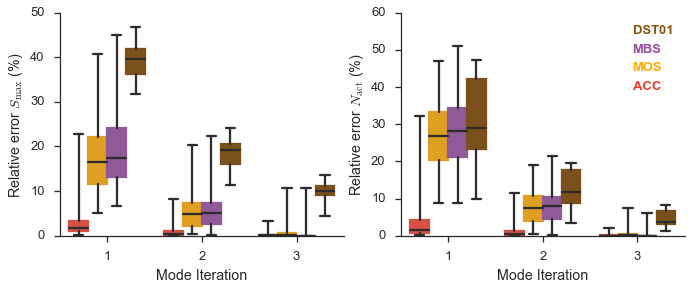

In [12]:
s = 'n_act'
c = 'rel'


size = 4
aspect = 1.4
nrows, ncols = 1, 2
width = size*aspect*ncols
height = size*nrows

print(width, height)
fig, axs = plt.subplots(1, 2, figsize=(width, height))
axl, axr = axs[:]

colors = {mode: mode_colors[mode]
          for mode in pd.unique(tidy_df_err['MODE_01'])}

def mode_iter_plot(variable, error, ax, plot_legend=False):
    tidy_df_err = pd.melt(df_err, 
                          id_vars=['MODE_{:02d}'.format(i) for i in range(1, niters+1)],
                          value_vars=[variable+'_err_'+error+"_{:02d}".format(i) 
                                      for i in range(1, niters+1)])

    sns.boxplot(x='variable', y='value', data=tidy_df_err,
                hue='MODE_01', whis=[1., 99.], showfliers=False,
                palette=colors, ax=ax)
    # sns.violinplot(x='variable', y='value', data=tidy_df_err,
    #                hue='MODE_01', scale='width', ax=ax)
    if plot_legend:
        leg = colortext_legend(colors, ax=ax, prop={'weight': 'bold'})
    else:
        ax.legend_.remove()
    
    ax.set_ylim(0.)
    # ylims = ax.get_ylim()
    # if ylims[0] < 0. < ylims[1]:
    #     ax.hlines(0, -1, niters, linestyle='dashed')

    ax.set_xlabel("Mode Iteration")
    ax.set_xticklabels(iter_range)
    
    sns.despine(ax=ax)
    
    return ax

axl = mode_iter_plot('smax', 'rel', axl)
axl.set_ylabel("Relative error $S_\mathrm{max}$ (%)")
axr = mode_iter_plot('n_act', 'rel', axr, plot_legend=True)
axr.set_ylabel("Relative error $N_\mathrm{act}$ (%)")

plt.subplots_adjust(hspace=0.4)

fig_fn = "figs/greedy_iteration_error"
plt.savefig(fig_fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fig_fn+".png", transparent=True, bbox_inches='tight', dpi=200)

## Fractional N vs Iteration

How does the fraction of the  total aerosol number concentration captured by the dominant modes after each iteration change?

In [175]:
n1 = df_err.apply(lambda x: x["n"+x.MODE_01], axis=1)
n2 = df_err.apply(lambda x: x["n"+x.MODE_01] + 
                            x["n"+x.MODE_02], axis=1)
n3 = df_err.apply(lambda x: x["n"+x.MODE_01] + 
                            x["n"+x.MODE_02] +
                            x["n"+x.MODE_03], axis=1)

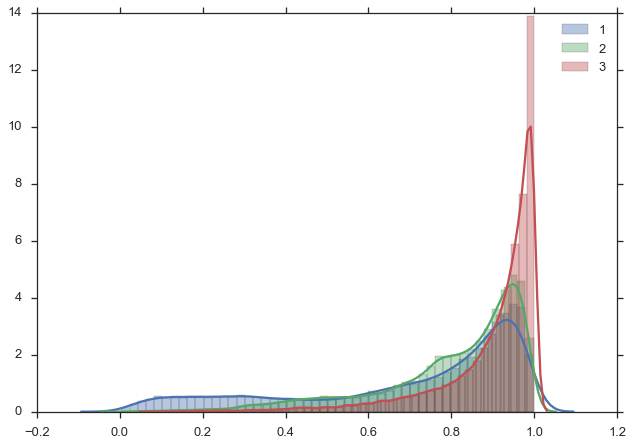

In [186]:
sns.distplot(n1 / df_err.N_TOT, label="1")
sns.distplot(n2 / df_err.N_TOT, label="2")
sns.distplot(n3 / df_err.N_TOT, label="3")
plt.legend()

In [194]:
(n3 / df_err.N_TOT).describe()

count    59513.000000
mean         0.895762
std          0.131985
min          0.077514
25%          0.865461
50%          0.945600
75%          0.982138
max          0.999901
dtype: float64

---


Decrease in absolute error in $N_\text{act}$ for each successive mode iteration.

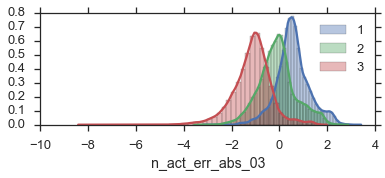

In [206]:
def _log10_err(x):
    y = x.copy()
    y[pd.isnull(y)] == np.nan
    y[y < 0] = np.nan
    y.dropna(inplace=True)
    return np.log10(y)

plt.figure(figsize=(6, 2))
sns.distplot(_log10_err(df_err.n_act_err_abs_01), label='1')
sns.distplot(_log10_err(df_err.n_act_err_abs_02), label='2')
sns.distplot(_log10_err(df_err.n_act_err_abs_03), label='3')
plt.legend()


In [211]:
df_err.n_act_err_abs_03.describe()

count    59513.000000
mean         0.484768
std          2.352538
min         -0.006766
25%          0.027967
50%          0.083942
75%          0.210393
max         56.964574
Name: n_act_err_abs_03, dtype: float64